In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')

## Define Custom Functions

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

## Load the Dataset

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/NHANES_Diet_Diabetes_Risk.xls.csv')
df = df.set_index("SEQN")
df.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6643 entries, 73557 to 83729
Data columns (total 168 columns):
 #    Column         Dtype  
---   ------         -----  
 0    WTDRD1         float64
 1    WTDR2D         float64
 2    DR1DRSTZ       int64  
 3    DR1EXMER       float64
 4    DRABF          float64
 5    DRDINT         float64
 6    DR1DBIH        float64
 7    DR1DAY         float64
 8    DR1LANG        float64
 9    DR1MNRSP       float64
 10   DR1HELPD       float64
 11   DBQ095Z        float64
 12   DBD100         float64
 13   DRQSPREP       float64
 14   DR1STY         float64
 15   DR1SKY         float64
 16   DRQSDIET       float64
 17   DRQSDT1        float64
 18   DRQSDT2        float64
 19   DRQSDT3        float64
 20   DRQSDT4        float64
 21   DRQSDT5        float64
 22   DRQSDT6        float64
 23   DRQSDT7        float64
 24   DRQSDT8        float64
 25   DRQSDT9        float64
 26   DRQSDT10       float64
 27   DRQSDT11       float64
 28   DRQSDT12   

In [6]:
df.dtypes.value_counts()

float64    166
int64        2
dtype: int64

In [7]:
df.isna().sum().sum()


432597

In [8]:
# Check to see if there are any duplicate rows
df.duplicated().sum()

511

In [9]:
# Remove duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

## Define X and y

In [10]:
# Define target and cols to drop
target_col = 'Diabetes_Risk'
# Define X and y
y = df[target_col].copy()
X = df.drop(columns=target_col).copy()

## Train Test Split

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)
X_train.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81209,61183.10616,84978.651520,1,71.0,2.0,2.0,39.0,4.0,1.0,1.0,13.0,1.0,2.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1795.0,137.37,165.53,26.31,8.7,62.55,13.419,24.761,17.971,335.0,8.74,0.00,64.0,69.0,18.0,26.0,59.0,0.0,100.0,1.971,1.881,45.857,2.821,254.0,93.0,161.0,319.0,500.1,12.04,0.00,76.3,20.8,41.2,371.0,1877.0,329.0,14.22,10.17,1.386,3465.0,2967.0,189.4,156.0,0.0,0.0,1898.98,0.005,0.007,0.075,0.099,0.427,0.751,7.937,3.579,1.005,22.486,0.984,0.077,14.610,1.606,0.115,0.176,0.342,0.155,0.753,2.0,760.5,0.0,760.5,99.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,2.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,1.0,4.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
82502,12559.90110,9519.716698,1,25.0,2.0,2.0,11.0,7.0,1.0,1.0,13.0,1.0,2.0,4.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,2304.0,89.10,242.24,99.06,17.2,108.82,48.117,27.991,15.338,898.0,6.19,0.00,760.0,788.0,12.0,298.0,117.0,1553.0,2158.0,1.160,2.146,15.939,1.257,299.0,151.0,146.0,404.0,625.2,6.05,1.05,6.5,6.2,30.5,1185.0,1705.0,244.0,16.11,13.52,0.781,4227.0,1557.0,144.3,84.0,0.0,0.0,2033.76,0.769,0.363,0.312,0.658,0.674,3.863,29.579,10.160,1.735,21.090,0.258,0.003,13.603,0.978,0.001,0.439,0.016,0.029,0.114,2.0,1050.0,1050.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82857,31975.90439,21778.114060,1,49.0,2.0,2.0,8.0,1.0,1.0,1.0,13.0,1.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2256.0,87.05,226.39,55.48,22.9,111.87,35.426,39.830,27.103,239.0,14.26,0.13,169.0,261.0,35.0,957.0,283.0,4576.0,750.0,1.243,1.465,24.576,1.736,319.0,148.0,170.0,421.0,196.4,3.61,0.00,110.0,0.5,118.9,975.0,1438.0,260.0,17.00,10.90,0.967,4869.0,2833.0,83.9,0.0,0.0,0.0,1507.59,0.686,0.166,0.223,0.398,0.302,3.188,19.164,9.231,2.303,33.272,0.362,0.016,23.668,3.104,0.003,0.169,0.004,0.019,0.008,3.0,210.0,0.0,210.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,N

## Scale Data and Impute missing value with the median

In [12]:
# Pipeline
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
pipe = make_pipeline(impute_median, scaler)

In [13]:
# Fit
pipe.fit(X_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [14]:
X_train_tf = pipe.transform(X_train)
X_test_tf = pipe.transform(X_test)
X_train_tf.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81209,0.491695,0.763514,-0.071563,1.331609,0.0,0.346115,2.004905,-0.214457,-0.269316,-0.075396,0.129235,-0.201930,0.291928,-0.978436,0.209707,-0.052264,0.191383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.070986,-0.292343,1.154565,-0.681847,-1.085023,-0.744489,-0.375376,-0.754705,-0.180131,-0.065378,0.174181,-0.000983,-0.188036,-0.861735,-0.937621,-0.332275,-0.480601,-0.067556,-0.578669,-0.428640,0.392842,-0.121960,1.120553,0.390540,-0.536840,-0.460117,-0.351352,-0.530932,0.798092,1.361512,-0.336075,-0.023451,2.679541,-0.431842,-0.941899,0.709256,0.253671,-0.016869,-0.097549,0.282664,-0.012140,0.354881,1.027936,0.197207,-0.429451,-0.311762,-0.553819,-0.976034,-0.960612,-0.666189,-0.859926,-0.313256,-0.754871,-0.708836,-0.662461,-0.066730,-0.171573,2.053881,0.504675,-0.172052,-0.094978,2.803762,0.108010,2.750319,3.158329,3.315562,-0.209621,-0.263728,-0.571977,0.284609,4.382552,-0.706344,0.255101,-0.126326,0.346902,-0.153436,0.164381,-0.066181,0.252675,-0.105831,0.200068,-0.105487,0.218193,-0.084598,0.240772,-0.101052,-0.267914,-0.093602,0.181071,-0.085413,0.051148,-0.028972,0.0,-0.509005,0.280294,-0.145643,0.581116,-0.106504,0.128757,-0.056471,-2.847267,3.949625,0.288777,0.007796,0.199479,-0.04099,0.162276,-0.086704,0.123417,-0.012463,0.117851,-0.066365,0.044281,-0.027878,0.134735,-0.061136,0.066089,-0.009326,0.557007,-0.11086,0.179787,-0.078633,0.114973,-0.058164,0.039043,-0.024584,0.094843,-0.038339,0.162276,-0.08135,0.064409,-0.035314,0.431894,-0.098855,0.214891,-0.025344,0.0
82502,-0.734599,-0.574503,-0.071563,-0.914358,0.0,0.346115,-0.428166,1.173379,-0.269316,-0.075396,0.129235,-0.201930,0.291928,0.671363,-1.162191,-0.052264,0.191383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.560686,0.207094,0.152147,-0.081711,-0.149502,0.062541,0.603212,1.345771,0.002853,-0.266720,2.431525,-0.323915,-0.188036,0.884024,0.345800,-0.338240,-0.415084,0.076377,-0.390621,0.209829,-0.469497,0.069768,-0.554574,-0.466072,-0.365679,-0.161054,-0.453409,-0.309334,1.377251,0.220733,-0.006584,-0.799650,0.253382,-0.497274,0.417962,0.474549,-0.290073,0.196163,0.368098,-0.527598,0.399149,-0.760889,0.398758,-0.229869,-0.429451,-0.311762,-0.464501,0.628888,0.226272,0.236291,0.388982,-0.118088,0.942432,1.760448,0.957713,0.808912,-0.257070,-0.199650,-0.278360,-0.258136,-0.553195,-0.259837,1.890423,-0.147719,0.096196,0.219610,-0.209621,-0.018221,0.483529,-0.536366,-0.256980,0.598789,0.255101,-0

In [15]:
# Check for class balance of target
y_train.value_counts(1)

0    0.825614
1    0.087628
2    0.086758
Name: Diabetes_Risk, dtype: float64

In [16]:
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

2    3797
0    3797
1    3797
Name: Diabetes_Risk, dtype: int64

## Time a model without PCA

In [17]:
# Fit KNN
knn = KNeighborsClassifier()
knn.fit(X_train_sm, y_train_sm)

KNeighborsClassifier()

In [18]:
# Record the time it takes to make predictions
%%time
preds = knn.predict(X_test_tf)


CPU times: user 592 ms, sys: 0 ns, total: 592 ms
Wall time: 363 ms


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.54      0.70      3797
           1       0.81      1.00      0.90      3797
           2       0.81      1.00      0.90      3797

    accuracy                           0.85     11391
   macro avg       0.87      0.85      0.83     11391
weighted avg       0.87      0.85      0.83     11391



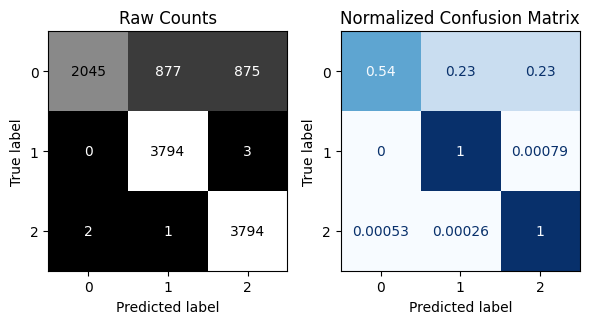


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.35      0.49      1260
           1       0.09      0.37      0.15       129
           2       0.10      0.36      0.16       144

    accuracy                           0.35      1533
   macro avg       0.35      0.36      0.27      1533
weighted avg       0.71      0.35      0.43      1533



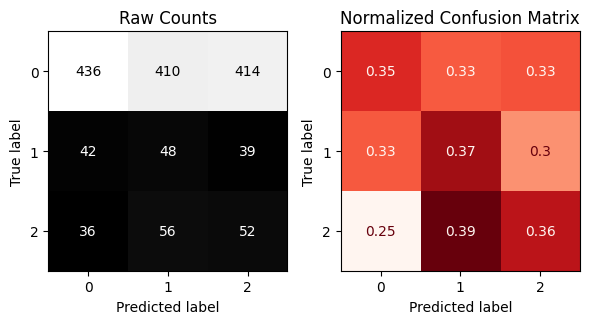

Training time was: 0:00:00.022126


In [19]:
# Import datetime library
import datetime as dt

# Record the start time
start = dt.datetime.now()

clf = KNeighborsClassifier()

clf.fit(X_train_sm, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_baseline = end-start

evaluate_classification(clf, X_train_sm,y_train_sm, X_test_tf, y_test)
print(f'Training time was: {dur_baseline}')

## PCA

Transform the data with PCA to keep 95% of the variance
Check to see how many Principal Components were created

In [20]:
# Define PCA to address 95% of the variance
pca95 = PCA(n_components=.95)
# fit and transform on training data
X_train_pca95 = pca95.fit_transform(X_train_sm)
# transform test data
X_test_pca95 = pca95.transform(X_test_tf)
# obtain the number of PCs used
pca95.n_components_

96

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.56      0.72      3797
           1       0.82      1.00      0.90      3797
           2       0.82      1.00      0.90      3797

    accuracy                           0.85     11391
   macro avg       0.88      0.85      0.84     11391
weighted avg       0.88      0.85      0.84     11391



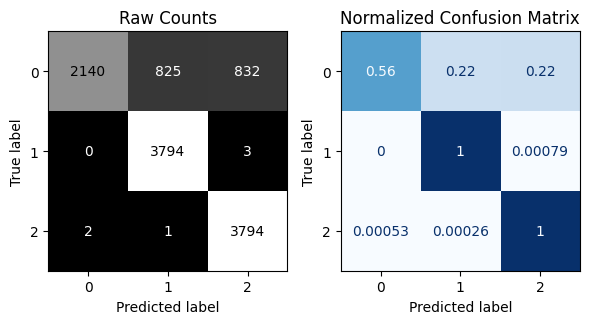


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.37      0.52      1260
           1       0.10      0.38      0.16       129
           2       0.10      0.33      0.15       144

    accuracy                           0.37      1533
   macro avg       0.35      0.36      0.28      1533
weighted avg       0.72      0.37      0.45      1533



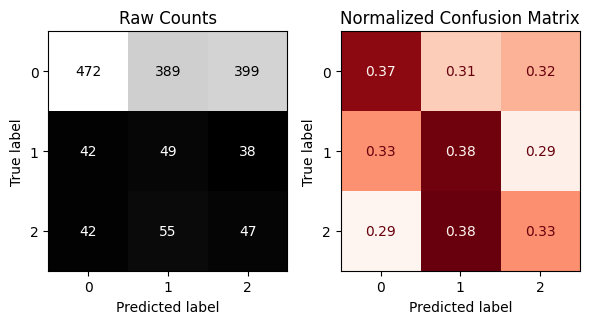

Training time was: 0:00:00.024706


In [21]:
# Record the start time
start = dt.datetime.now()


knn_pca = KNeighborsClassifier()

knn_pca.fit(X_train_pca95, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_pca_95 = end-start

evaluate_classification(knn_pca, X_train_pca95,y_train_sm, X_test_pca95, y_test)
print(f'Training time was: {dur_pca_95}')

In [22]:
# Record the time it takes to make predictions with PCA data
%%time
preds_pca = knn_pca.predict(X_test_pca95)



CPU times: user 714 ms, sys: 9.9 ms, total: 724 ms
Wall time: 709 ms


## Compare the Models

In [24]:
compare_speed = dur_baseline/dur_pca_95
print(f"Using PC's with .95 was {compare_speed:.2f} times faster!")

Using PC's with .95 was 0.90 times faster!


Q1. There were 168 features used in the first model and 96 components.

Q2. The PCA model performed marginally better or the same across all metrics on the test set. With an f-1 score of 52.

Q3. The PCA model performed the fastest by .90 times.